In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
loggingSchema = StructType() \
        .add("window",StructType()\
             .add("start",TimestampType())\
             .add("end",TimestampType()))\
        .add("system", StringType())\
        .add("count", LongType())

In [3]:
logDiffSchema = StructType() \
        .add("window",StructType()\
             .add("start",TimestampType())\
             .add("end",TimestampType()))\
        .add("system", StringType())\
        .add("count", LongType())\
        .add("avg", DoubleType())\
        .add("diff", DoubleType())\
        .add("%diff", DoubleType())\
        .add("label", IntegerType())

In [4]:
# raw_data = spark\
# .readStream.format("parquet")\
# .schema(loggingSchema)\
# .load("/cms/users/carizapo/ming/groupdata_cmsweb_logs");
# raw_data.printSchema()

In [5]:
raw_diff_data = spark\
.readStream.format("parquet")\
.schema(logDiffSchema)\
.load("/cms/users/carizapo/ming/diff_data_cmsweb_logs");
raw_diff_data.printSchema()

root
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- system: string (nullable = true)
 |-- count: long (nullable = true)
 |-- avg: double (nullable = true)
 |-- diff: double (nullable = true)
 |-- %diff: double (nullable = true)
 |-- label: integer (nullable = true)



In [6]:
# raw_data_match = raw_data.withColumn('date',col("window.start")).drop(col("window"))\

In [7]:
raw_diff_data_match = raw_diff_data.withColumn('date',col("window.start")).drop(col("window"))\

In [8]:
# raw_data_flow = raw_data.writeStream.queryName("hdfs").outputMode("Append").format("memory").start()

In [9]:
raw_diff_data_flow = raw_diff_data.writeStream.queryName("diff_hdfs").outputMode("Append").format("memory").start()

In [11]:
# raw_data_flow.lastProgress

In [15]:
raw_diff_data_flow.lastProgress

{'id': '283db117-1f2c-43a6-99d6-6c285e64847b',
 'runId': '8414f834-c2a9-45eb-9602-883a17925d1a',
 'name': 'diff_hdfs',
 'timestamp': '2019-07-16T08:39:56.380Z',
 'batchId': 1,
 'numInputRows': 0,
 'inputRowsPerSecond': 0.0,
 'processedRowsPerSecond': 0.0,
 'durationMs': {'getOffset': 161, 'triggerExecution': 161},
 'stateOperators': [],
 'sources': [{'description': 'FileStreamSource[hdfs://analytix/cms/users/carizapo/ming/diff_data_cmsweb_logs]',
   'startOffset': {'logOffset': 0},
   'endOffset': {'logOffset': 0},
   'numInputRows': 0,
   'inputRowsPerSecond': 0.0,
   'processedRowsPerSecond': 0.0}],
 'sink': {'description': 'MemorySink'}}

In [ ]:
# alerts = spark.sql("select * from hdfs")
# # alerts.show()

In [16]:
alerts = spark.sql("select * from diff_hdfs")
# alerts.show()

In [17]:
from pyspark.sql.window import Window as W
raw_data_id = alerts.select("system").distinct()
windowSpec = W.orderBy("system")
raw_data_id=raw_data_id.withColumn("systemID", row_number().over(windowSpec)).withColumnRenamed("system","tempSystem")

In [18]:
alerts_df=alerts\
.join(raw_data_id, raw_data_id.tempSystem == alerts.system)\
.withColumn('date',col("window.start")).drop(col("window"))\
.drop(raw_data_id.tempSystem)

In [ ]:
alerts_df.show()

In [19]:
alerts_pd=alerts_df.toPandas()

In [113]:
import matplotlib.pyplot as plt
import pandas as pd
filter_data=alerts_pd[(alerts_pd.system =='couchdb')]

In [114]:
filter_data.set_index('date', inplace=True)

In [115]:
# prep=filter_data[['count']]
prep=filter_data[['%diff']]
# print(prep.sort_values(by='date'))

In [116]:
# prep.dropna()
prep.head(10)

,%diff
date,
2019-06-28 17:04:00,1.006085
2019-06-29 09:29:00,2.672750
2019-06-29 16:29:00,1.968583
2019-06-29 17:57:00,-0.038451
2019-07-01 04:57:00,-0.788352
2019-07-02 06:30:00,1.969414
2019-07-02 06:43:00,0.368057
2019-07-02 09:43:00,-0.976451
2019-07-02 21:29:00,0.528810


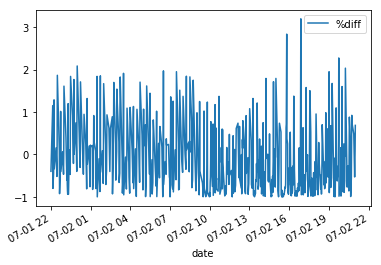

In [132]:
%matplotlib inline

prep_fix=prep.loc['2019-07-1 22:00:00':'2019-07-2 21:00:00']
prep_fix.plot()
# prep.plot()

In [133]:
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [134]:
# fix random seed for reproducibility
np.random.seed(7)

In [135]:
prep_fix=prep_fix.sort_values("date")

In [172]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1,1))
dataset = scaler.fit_transform(prep_fix)

In [173]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

446 220


In [174]:
# convert an array of values into a dataset matrix
# Look_Back is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(dataY)
    return np.array(dataX), np.array(dataY)

In [175]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

[0.025290866166221226, -0.9051698545315747, -0.7273279895952613, -0.38399988690501446, 0.08972673424092048, -0.68452153752633, -0.4504431909750202, -0.7708412853245119, -0.39041802734071285, 0.3656784992295402, -0.4789431273590908, -0.9640640683093713, -0.7471196120841992, -0.5548864102237868, -0.03973875058314613, -0.7166122397048221, -0.4921469669338537, -0.7464975896631183, -0.5138046566860343, 0.24384692593692103, -0.3302514949743417, -0.8119513126086773, -0.49853683362313933, -0.8576134130652983, -0.9336415171692325, -0.9705953037307209, -0.8374542318729943, 0.04731611462176777, -0.9720372647977721, -0.47190296450231145, -0.7481657407014717, -0.23779634420458895, 0.3530684083294455, -0.09102732657590806, -0.6244963738920226, -0.18252116996762668, 0.31848961646662977, -0.5228522555381202, -0.16835602301482971, -0.7140958762740858, -0.042905410181376225, 0.47034790844960883, -0.28368463463251203, -0.6692254407170223, -0.37599841667020095, 0.29171437861373806, -0.4577095438031017, -0

In [176]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [177]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.2069
Epoch 2/100
 - 1s - loss: 0.1254
Epoch 3/100
 - 1s - loss: 0.1247
Epoch 4/100
 - 1s - loss: 0.1240
Epoch 5/100
 - 1s - loss: 0.1243
Epoch 6/100
 - 1s - loss: 0.1236
Epoch 7/100
 - 1s - loss: 0.1236
Epoch 8/100
 - 1s - loss: 0.1234
Epoch 9/100
 - 1s - loss: 0.1231
Epoch 10/100
 - 1s - loss: 0.1229
Epoch 11/100
 - 1s - loss: 0.1226
Epoch 12/100
 - 1s - loss: 0.1224
Epoch 13/100
 - 1s - loss: 0.1221
Epoch 14/100
 - 1s - loss: 0.1221
Epoch 15/100
 - 1s - loss: 0.1216
Epoch 16/100
 - 1s - loss: 0.1212
Epoch 17/100
 - 1s - loss: 0.1207
Epoch 18/100
 - 1s - loss: 0.1203
Epoch 19/100
 - 1s - loss: 0.1200
Epoch 20/100
 - 1s - loss: 0.1198
Epoch 21/100
 - 1s - loss: 0.1189
Epoch 22/100
 - 1s - loss: 0.1183
Epoch 23/100
 - 1s - loss: 0.1184
Epoch 24/100
 - 1s - loss: 0.1177
Epoch 25/100
 - 1s - loss: 0.1168
Epoch 26/100
 - 1s - loss: 0.1166
Epoch 27/100
 - 1s - loss: 0.1169
Epoch 28/100
 - 1s - loss: 0.1167
Epoch 29/100
 - 1s - loss: 0.1159
Epoch 30/100
 - 1s - lo

In [178]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None


In [179]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.71 RMSE
Test Score: 0.70 RMSE


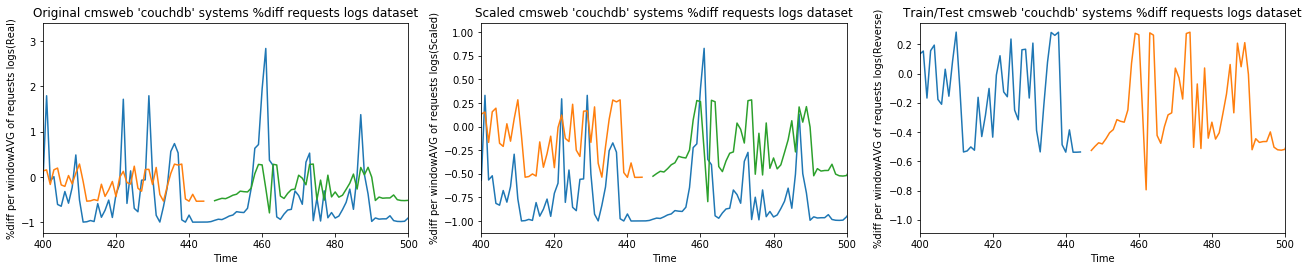

In [198]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions

fig, (ax1, ax2,ax3) = plt.subplots(nrows=1, ncols=3)

ax1.plot(scaler.inverse_transform(dataset))
ax1.plot(trainPredictPlot)
ax1.plot(testPredictPlot)
ax1.set_title('Original cmsweb \'couchdb\' systems %diff requests logs dataset')
ax1.set_ylabel('%diff per windowAVG of requests logs(Real)')
ax1.set_xlabel('Time')

ax2.plot(dataset)
ax2.plot(trainPredictPlot)
ax2.plot(testPredictPlot)
ax2.set_title('Scaled cmsweb \'couchdb\' systems %diff requests logs dataset')
ax2.set_ylabel('%diff per windowAVG of requests logs(Scaled)')
ax2.set_xlabel('Time')

ax3.plot(trainPredictPlot)
ax3.plot(testPredictPlot)
ax3.set_title('Train/Test cmsweb \'couchdb\' systems %diff requests logs dataset')
ax3.set_ylabel('%diff per windowAVG of requests logs(Reverse)')
ax3.set_xlabel('Time')

plt.subplots_adjust(bottom=0.15,right = 3, wspace=0.2)
plt.show()

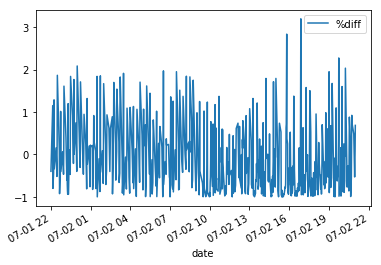

In [165]:
prep_fix.plot()

Some shifting occured since we transform it to supervised learning (t-1 as input and t as output)

In [ ]:
prep_fix['train']=trainPredictPlot
prep_fix['test']=testPredictPlot

In [ ]:
prep_fix.head()